
# FHIR Mapping / Extraction Accuracy — Demo Notebook

Author: Ishaan Kejriwal \
Date: 10/15/2025 \
Purpose: Evaluate the accuracy of NLP and LLM systems in mapping extracted clinical data to standardized FHIR fields using precision, recall, and F1 metrics to ensure reliable, interoperable structured data for downstream clinical use. 



---

## Table of Contents

1. [Overview](#overview)  
2. [Metric Definition](#metric-definition)  
3. [Helper Functions](#helper-functions)  
4. [Sample Data & Comparison Setup](#data-setup)  
5. [Scoring & Aggregation](#scoring)  
6. [Evaluation Demo & Results](#evaluation-results) 
7. [Save Evaluation Summary](#save-summary)   
8. [How to use with your data](#8-how-to-use-with-your-data)
9. [Results Visualization & Export](#results-visualization)


Import necessary libraries for notebook

In [1]:
from typing import List, Dict, Any, Tuple
from collections import defaultdict
import json
from typing import List
import os, datetime, math
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

## 1. Overview <a name="overview"></a>

This notebook implements an evaluation for **FHIR Mapping Accuracy**.  
It mirrors a simple *auto-eval* structure:
- Define a small set of clinical text samples or notes.
- Collect model outputs mapped to FHIR resources (mocked here for demonstration, but works identically with real outputs).
- Extract structured entities (e.g., Observations, Medications, Conditions) from each output.
- Compare predicted mappings against gold-standard FHIR JSONs or reference tables.
- Aggregate metrics: precision, recall, and F1 for extraction, normalization, and full FHIR field mapping.

<div id="toc"></div>


## 2. Metric Definition <a name="metric-definition"></a>

**Metric**: *FHIR Mapping Accuracy*  
**Objective**: Measure how effectively NLP or LLM systems extract, normalize, and map unstructured clinical data into valid FHIR resources.

**What we check:**
- Extraction: Does the system correctly identify the relevant clinical concept or entity (e.g., medication, lab, diagnosis)?
- Normalization: Is the extracted entity mapped to the correct standardized code (e.g., SNOMED CT, RxNorm, LOINC, UCUM)?
- Field Mapping: Are key FHIR fields (e.g., `value[x]`, `code`, `unit`, `effectiveDateTime`) correctly populated and consistent with the gold standard?
- Schema Validity: Does the predicted JSON conform to the FHIR schema for its declared resource type?

**Recommended summary KPIs:**
- `Precision`, `Recall`, and `F1` for extraction, normalization, and full mapping
- `% valid FHIR resources` (JSON passes schema validation)
- `per-resource breakdown` (Observation, Medication, Condition, etc.)
- `common error patterns` (missing fields, incorrect codes, wrong units)

**Suggested pass criteria (tunable):**
- Overall F1 ≥ `0.80`
- Normalization accuracy ≥ `0.85`
- ≥ `95%` of generated FHIR JSONs pass schema validation


## 3. Helper Functions <a name="helper-functions"></a>

This section defines utility functions used throughout the evaluation:
- **`normalize_str` / `normalize_code`**: clean and standardize strings and FHIR `Coding` elements for fair comparison.  
- **`eq_strict` / `eq_lenient`**: perform equality checks between predicted and gold values, with lenient options allowing for normalized text and unordered lists of codings.  
- **`precision_recall_f1`**: compute the standard precision, recall, and F1 metrics from true positive (TP), false positive (FP), and false negative (FN) counts.


In [ ]:


# Normalize a string by stripping whitespace, lowercasing, and collapsing internal spaces.
def normalize_str(s: str) -> str:
    if (s is None):
        return ""
    return " ".join(str(s).strip().lower().split())

# Extract and normalize 'system', 'code', and 'display' fields from a coding dictionary
def normalize_code(coding: Dict[str, Any]) -> Tuple[str, str, str]:
    system = normalize_str(coding.get("system", ""))
    code = normalize_str(coding.get("code", ""))
    display = normalize_str(coding.get("display", ""))
    return (system, code, display)

# Perform strict equality comparison.
def eq_strict(a: Any, b: Any) -> bool:
    return a == b


#Lenient equality check with normalization and deep comparison for strings, dicts, and lists.
def eq_lenient(a: Any, b: Any) -> bool:
    # Compare normalized strings
    if (isinstance(a, str) and isinstance(b, str)):
        return normalize_str(a) == normalize_str(b)
    
    # Compare dictionaries by matching keys and recursively checking values
    if (isinstance(a, dict) and isinstance(b, dict)):
        if (set(a.keys()) != set(b.keys())):
            return False
        return all(eq_lenient(a[k], b[k]) for k in a)

    # Compare lists, handling FHIR-like coding lists specially    
    if (isinstance(a, list) and isinstance(b, list)):
        # Normalize coding lists (objects with system/code/display)
        if (all(isinstance(x, dict) and ('system' in x or 'code' in x or 'display' in x) for x in a) and
            all(isinstance(x, dict) and ('system' in x or 'code' in x or 'display' in x) for x in b)):
            aa = sorted([normalize_code(x) for x in a])
            bb = sorted([normalize_code(x) for x in b])
            return aa == bb

        # Compare generic lists element-wise    
        if (len(a) != len(b)):
            return False
        return all(eq_lenient(x, y) for x, y in zip(a, b))
        
    # Default strict equality for other types    
    return a == b

# Return precision, recall, and F1-score from true/false positive/negative counts.
def precision_recall_f1(tp: int, fp: int, fn: int):
    p = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f = 2*p*r/(p+r) if (p+r) > 0 else 0.0
    return p, r, f


## 4. Sample Data & Comparison Setup <a name="data-setup"></a>

This section defines example **gold-standard** and **predicted** FHIR resources to demonstrate the evaluation logic.

- `gold`: reference (“correct”) FHIR resources for comparison  
- `pred_strictish`: mostly correct predictions (minor casing/value differences)  
- `pred_with_errors`: predictions with noticeable mapping errors  

It also specifies required fields for each resource type and defines helper utilities for field access and comparison.


In [5]:

gold = [
    {
        "resourceType": "MedicationStatement",
        "id": "med-1",
        "medicationCodeableConcept": {
            "coding": [
                {"system": "http://www.nlm.nih.gov/research/umls/rxnorm", "code": "12345", "display": "Atorvastatin 10 MG"}
            ],
            "text": "Atorvastatin 10 mg"
        },
        "form": "tablet",
        "dosage": {
            "text": "10 mg daily",
            "timing": {
                "repeat": {"frequency": 1, "period": 1, "periodUnit": "d", "when": ["QD"]}
            }
        }
    },
    {
        "resourceType": "Observation",
        "id": "obs-ahi",
        "code": {"text": "Apnea-Hypopnea Index"},
        "valueQuantity": {"value": 15.2, "unit": "/hr"},
        "interpretation": "moderate"
    },
    {
        "resourceType": "Observation",
        "id": "obs-sao2",
        "code": {"text": "Oxygen Saturation (SaO2)"},
        "valueQuantity": {"value": 0.92, "unit": ""},
        "interpretation": "low"
    }
]

pred_strictish = [
    {
        "resourceType": "MedicationStatement",
        "id": "med-1",
        "medicationCodeableConcept": {
            "coding": [
                {"system": "http://www.nlm.nih.gov/research/umls/rxnorm", "code": "12345", "display": "atorvastatin 10 mg"}
            ],
            "text": "atorvastatin 10 mg"
        },
        "form": "Tablet",
        "dosage": {
            "text": "10 MG daily",
            "timing": {
                "repeat": {"frequency": 1, "period": 1, "periodUnit": "d", "when": ["qd"]}
            }
        }
    },
    {
        "resourceType": "Observation",
        "id": "obs-ahi",
        "code": {"text": "apnea hypopnea index"},
        "valueQuantity": {"value": 15.2, "unit": "/hr"},
        "interpretation": "Moderate"
    },
    {
        "resourceType": "Observation",
        "id": "obs-sao2",
        "code": {"text": "oxygen saturation (sao2)"},
        "valueQuantity": {"value": 0.91, "unit": ""},
        "interpretation": "low"
    }
]

pred_with_errors = [
    {
        "resourceType": "MedicationStatement",
        "id": "med-1",
        "medicationCodeableConcept": {
            "coding": [
                {"system": "http://www.nlm.nih.gov/research/umls/rxnorm", "code": "99999", "display": "Simvastatin 10 mg"}
            ],
            "text": "Simvastatin 10 mg"
        },
        "form": "capsule",
        "dosage": {
            "text": "10 mg twice daily",
            "timing": {"repeat": {"frequency": 2, "period": 1, "periodUnit": "d", "when": ["BID"]}}
        }
    },
    {
        "resourceType": "Observation",
        "id": "obs-ahi",
        "code": {"text": "AHI index"},
        "valueQuantity": {"value": 9.0, "unit": "/hr"},
        "interpretation": "mild"
    },
    {
        "resourceType": "Observation",
        "id": "obs-sao2",
        "code": {"text": "SaO2"},
        "valueQuantity": {"value": 0.98, "unit": ""},
        "interpretation": "normal"
    }
]


## 5. Scoring & Aggregation <a name="scoring"></a>

This section defines the main scoring logic used to evaluate **FHIR Mapping Accuracy**.

- Aligns gold and predicted resources by ID  
- Compares each required field using either *strict* or *lenient* matching  
- Aggregates per-field true positives, false positives, and false negatives  
- Computes overall micro/macro precision, recall, and F1 scores  
- Reports resource-level accuracy (% of resources with all required fields correct)


In [8]:
# REQUIRED_FIELDS defines, for each FHIR resource type, which fields must be present
# and will be scored. Paths are dot-separated to allow nested lookup.
REQUIRED_FIELDS = {
    "MedicationStatement": [
        "medicationCodeableConcept.coding", 
        "form",
        "dosage.text",
        "dosage.timing.repeat.frequency",
        "dosage.timing.repeat.period",
        "dosage.timing.repeat.periodUnit",
        "dosage.timing.repeat.when"
    ],
    "Observation": [
        "code.text",
        "valueQuantity.value",
        "interpretation"
    ]
}

#   Build a {resource_id -> resource_dict} index for O(1) matching between gold and predicted resources.
#   We assume IDs are shared across gold/pred
def get_index_by_id(resources: List[Dict[str, Any]]) -> Dict[str, Dict[str, Any]]:
    return {r.get("id"): r for r in resources}

# Safely fetch a nested value from a dict using a dot path, e.g. 'dosage.timing.repeat.frequency'.
# Returns None if any hop is missing
# This lets us treat 'missing field' cleanly during scoring.    
def get_by_path(obj: Dict[str, Any], path: str):
    parts = path.split(".")
    cur = obj
    for p in parts:
        if (cur is None):
            return None
        if (isinstance(cur, dict)):
            cur = cur.get(p)
        else:
             # If we encounter a non-dict before the path ends, treat as missing
            return None
    return cur



"""
Compare a single field under a given policy.
    - 'strict': exact match via eq_strict (e.g., same strings, same lists, same numbers).
    - 'lenient': allows small numeric tolerance and normalized string/list comparisons
                 via eq_lenient.
Returns True if values are considered equivalent under the policy.
"""
def compare_field(gold_val, pred_val, policy: str) -> bool:
    if (policy == "strict"):
        return eq_strict(gold_val, pred_val)
    if (policy == "lenient"):
        # Small numeric tolerance: within 5% of the gold value (min scale 1.0)
        if (isinstance(gold_val, (int, float)) and isinstance(pred_val, (int, float))):
            return abs(gold_val - pred_val) <= 0.05 * max(1.0, abs(gold_val))
        return eq_lenient(gold_val, pred_val)
    raise ValueError("Unknown policy")



"""
    Core evaluator for 'FHIR Mapping Accuracy' on a matched set of resources.

    Inputs:
      - gold: list of gold-standard FHIR resources (dicts with 'id' and 'resourceType').
      - pred: list of predicted FHIR resources aligned to gold by the same 'id'.
      - policy: 'lenient' (default) or 'strict' for matching rules.

    Method:
      1) Index gold and predicted by 'id' for alignment.
      2) For each gold resource, fetch the required fields determined by its resourceType.
      3) For each field:
           - If gold has value and pred is missing => FN (missed).
           - If gold is missing and pred has value => FP (spurious).
           - If both present => compare under policy:
                * match => TP
                * mismatch => count both an FN and an FP (wrong value supplied).
         We also track a per-resource "all required fields correct" boolean for resource-level accuracy.
      4) Aggregate:
           - Micro precision/recall/F1 over all required fields across all resources.
           - Macro F1: mean of per-field F1 across all distinct required fields.
           - Resource accuracy: fraction of resources where all required fields were correct.

    Outputs:
      {
        "policy": ...,
        "micro": {"precision": P, "recall": R, "f1": F},
        "macro": {"f1": macro_f},
        "per_field": { field_path: {"tp":..., "fp":..., "fn":...}, ... },
        "resource_accuracy": fraction_of_resources_fully_correct
      }
    """

def score_resources(gold: List[Dict[str, Any]], pred: List[Dict[str, Any]], policy: str = "lenient"):
    gidx = get_index_by_id(gold)
    pidx = get_index_by_id(pred)

    # per_field accumulates confusion counts per required field path
    per_field = defaultdict(lambda: {"tp":0,"fp":0,"fn":0})
    # per_res_correct tracks if each resource had ALL its required fields correct (1) or not (0)
    per_res_correct = []

    for rid, g in gidx.items():
        rt = g.get("resourceType")
        fields = REQUIRED_FIELDS.get(rt, [])
        p = pidx.get(rid)
        ok = True # flips to False if any required field fails

        for f in fields:
            gval = get_by_path(g, f)
            pval = get_by_path(p, f) if (p is not None) else None

            if (pval is None and gval is not None):
                # predicted missing something present in gold => miss
                per_field[f]["fn"] += 1
                ok = False

            elif (gval is None and pval is not None):
                # predicted invented a field the gold does not have => spurious
                per_field[f]["fp"] += 1
                ok = False

            elif (gval is None and pval is None):
                # both absent => do not count; we only score fields that exist in gold
                # (design choice: treat "not applicable" as neutral)
                pass
            else:
                # both present => compare values under the chosen policy
                if (compare_field(gval, pval, policy)):
                    per_field[f]["tp"] += 1
                else:
                     # wrong value: we count both a miss (FN) and a wrong assertion (FP)
                    per_field[f]["fn"] += 1; per_field[f]["fp"] += 1; ok = False
        per_res_correct.append(1 if ok else 0)

    # Micro-averaged totals across all required fields    
    tp = sum(v["tp"] for v in per_field.values())
    fp = sum(v["fp"] for v in per_field.values())
    fn = sum(v["fn"] for v in per_field.values())
    P, R, F = precision_recall_f1(tp, fp, fn)

    # Macro F1: average of per-field F1 across all field paths
    macro_f = 0.0
    if (per_field):
        macro_f = sum(precision_recall_f1(v["tp"], v["fp"], v["fn"])[2] for v in per_field.values()) / len(per_field)

    # Resource accuracy: percentage of resources that are "perfect" on all required fields
    res_acc = sum(per_res_correct)/len(per_res_correct) if per_res_correct else 0.0
    
    return {
        "policy": policy,
        "micro": {"precision": P, "recall": R, "f1": F},
        "macro": {"f1": macro_f},
        "per_field": dict(per_field),
        "resource_accuracy": res_acc
    }


## 6. Evaluation Demo & Results <a name="evaluation-results"></a>

This section runs the evaluation using both *lenient* and *strict* comparison policies.

- **Minor format mismatches:** compares `pred_strictish` against gold — shows how normalization handles small text or value differences.  
- **Substantive errors:** compares `pred_with_errors` against gold — demonstrates how genuine mapping mistakes affect scores.  

Each run prints micro/macro F1 metrics, per-field stats, and overall resource accuracy in formatted JSON for easy inspection.


In [21]:

res_lenient_ok = score_resources(gold, pred_strictish, policy="lenient")
res_strict_ok = score_resources(gold, pred_strictish, policy="strict")
res_lenient_err = score_resources(gold, pred_with_errors, policy="lenient")
res_strict_err = score_resources(gold, pred_with_errors, policy="strict")

print("=== Minor format mismatches ===")
print(json.dumps(res_lenient_ok, indent=2))
print(json.dumps(res_strict_ok, indent=2))

print("\n=== Substantive errors ===")
print(json.dumps(res_lenient_err, indent=2))
print(json.dumps(res_strict_err, indent=2))


=== Minor format mismatches ===
{
  "policy": "lenient",
  "micro": {
    "precision": 0.9230769230769231,
    "recall": 0.9230769230769231,
    "f1": 0.9230769230769231
  },
  "macro": {
    "f1": 0.95
  },
  "per_field": {
    "medicationCodeableConcept.coding": {
      "tp": 1,
      "fp": 0,
      "fn": 0
    },
    "form": {
      "tp": 1,
      "fp": 0,
      "fn": 0
    },
    "dosage.text": {
      "tp": 1,
      "fp": 0,
      "fn": 0
    },
    "dosage.timing.repeat.frequency": {
      "tp": 1,
      "fp": 0,
      "fn": 0
    },
    "dosage.timing.repeat.period": {
      "tp": 1,
      "fp": 0,
      "fn": 0
    },
    "dosage.timing.repeat.periodUnit": {
      "tp": 1,
      "fp": 0,
      "fn": 0
    },
    "dosage.timing.repeat.when": {
      "tp": 1,
      "fp": 0,
      "fn": 0
    },
    "code.text": {
      "tp": 1,
      "fp": 1,
      "fn": 1
    },
    "valueQuantity.value": {
      "tp": 2,
      "fp": 0,
      "fn": 0
    },
    "interpretation": {
      "tp": 2,

## 7. Save Evaluation Summary <a name="save-summary"></a>

This section consolidates all results into a structured JSON summary and saves it locally.

- Combines lenient and strict evaluation outputs into a single `summary` dictionary.  
- Includes run metadata (timestamp, notes).  
- Writes results to `outputs/fhir_mapping_accuracy_results.json` for reproducibility and downstream analysis.


In [ ]:
# --- Summarize evaluation results ---
summary = {
    "metric_name": "FHIR Mapping / Extraction Accuracy",
    "policies": {
        "lenient": res_lenient_ok,
        "strict": res_strict_ok
    },
    
    "metadata": {
        "created": datetime.datetime.now().isoformat(),
        "notes": "Synthetic demo"
    }
}

# --- Choose an output path that always works locally ---
out_dir = "outputs"
os.makedirs(out_dir, exist_ok=True)
out_json = os.path.join(out_dir, "fhir_mapping_accuracy_results.json")

# --- Write results to JSON file ---
with open(out_json, "w") as f:
    json.dump(summary, f, indent=2)

print(f"Results saved to {out_json}")

Results saved to outputs\fhir_mapping_accuracy_results.json



## 8. How to Use With Your Data <a name="Data"></a>
1. Replace `gold` and `pred_*` lists with your FHIR-like dicts (stable `id` required).
2. Edit `REQUIRED_FIELDS` to match target elements.
3. Extend `compare_field`/`eq_lenient` for domain tolerances (rounding, unit conversion, code system mapping).
4. Re-run and collect the JSON export for dashboards.

## Interpretation
- **Micro F1**: overall field correctness.
- **Macro F1**: balances per-field; highlights weak spots.
- **Resource accuracy**: all-required-fields-correct view.
- **Lenient vs Strict**: development vs pre-deployment expectations.


## 9. Results Visualization & Export <a name="results-visualization"></a>

This section loads evaluation outputs (either from memory or the saved JSON summary) and visualizes key results.

- **Data handling**
  - Tries to reuse `res_lenient_ok` / `res_strict_ok` from earlier cells; if missing, loads from `outputs/fhir_mapping_accuracy_results.json`.
  - Builds clean pandas DataFrames for per-field metrics using `df_from_result()`.

- **Visualizations**
  - Displays sorted per-field tables (lenient vs. strict).
  - Generates bar charts for:
    - Per-field F1 scores
    - Total error counts (FP + FN)
  - Prints headline micro-level F1, precision, recall, and resource-level accuracy.

- **Exports**
  - Saves the per-field results as timestamped CSVs under the `outputs/` directory for downstream analysis.


,field,tp,fp,fn,precision,recall,f1,errors
0,code.text,1,1,1,0.5,0.5,0.5,2
1,medicationCodeableConcept.coding,1,0,0,1.0,1.0,1.0,0
2,form,1,0,0,1.0,1.0,1.0,0
3,dosage.text,1,0,0,1.0,1.0,1.0,0
4,dosage.timing.repeat.frequency,1,0,0,1.0,1.0,1.0,0
5,dosage.timing.repeat.period,1,0,0,1.0,1.0,1.0,0
6,dosage.timing.repeat.periodUnit,1,0,0,1.0,1.0,1.0,0
7,dosage.timing.repeat.when,1,0,0,1.0,1.0,1.0,0
8,valueQuantity.value,2,0,0,1.0,1.0,1.0,0
9,interpretation,2,0,0,1.0,1.0,1.0,0


,field,tp,fp,fn,precision,recall,f1,errors
0,code.text,0,2,2,0.0,0.0,0.0,4
1,medicationCodeableConcept.coding,0,1,1,0.0,0.0,0.0,2
2,form,0,1,1,0.0,0.0,0.0,2
3,dosage.text,0,1,1,0.0,0.0,0.0,2
4,dosage.timing.repeat.when,0,1,1,0.0,0.0,0.0,2
5,valueQuantity.value,1,1,1,0.5,0.5,0.5,2
6,interpretation,1,1,1,0.5,0.5,0.5,2
7,dosage.timing.repeat.frequency,1,0,0,1.0,1.0,1.0,0
8,dosage.timing.repeat.period,1,0,0,1.0,1.0,1.0,0
9,dosage.timing.repeat.periodUnit,1,0,0,1.0,1.0,1.0,0


LENIENT  | micro F1=0.923  P=0.923  R=0.923  resource_acc=0.667
STRICT   | micro F1=0.385  P=0.385  R=0.385  resource_acc=0.000


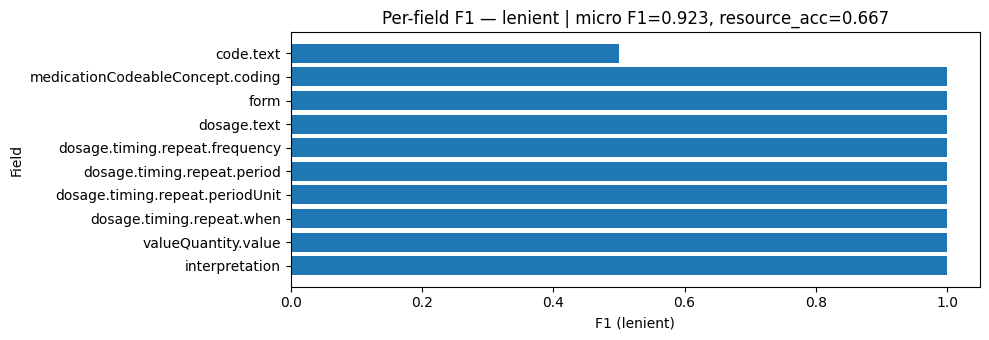

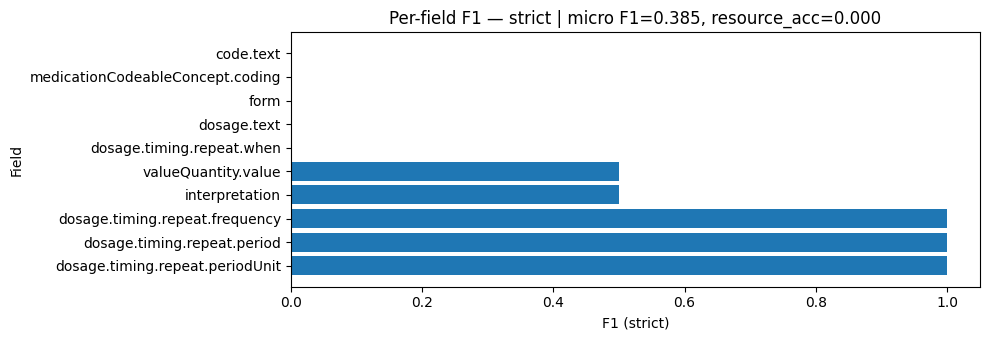

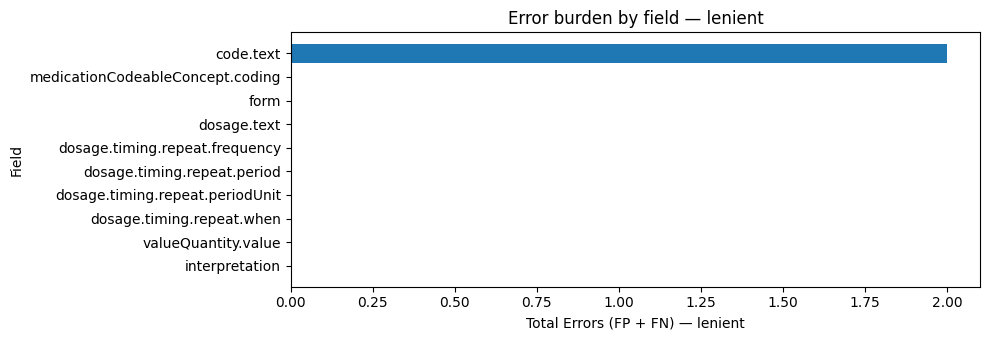

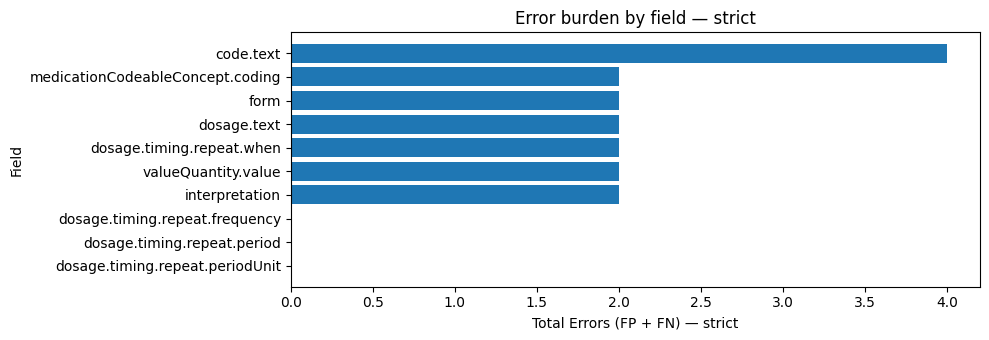

Saved CSVs:
- outputs\per_field_lenient_20251015_023932.csv
- outputs\per_field_strict_20251015_023932.csv


In [ ]:
res_lenient = None
res_strict = None

# 1) Try variables defined earlier in the notebook
if ("res_lenient_ok" in globals()) and ("res_strict_ok" in globals()):
    res_lenient = res_lenient_ok
    res_strict  = res_strict_ok
else:
    # 2) Fallback: try to load from JSON summary saved earlier
    fallback_json = os.path.join("outputs", "fhir_mapping_accuracy_results.json")
    if os.path.exists(fallback_json):
        with open(fallback_json, "r") as f:
            data = json.load(f)
        pol = data.get("policies", {})
        res_lenient = pol.get("lenient")
        res_strict  = pol.get("strict")

# Final guard
if (res_lenient is None) or (res_strict is None):
    raise RuntimeError(
        "Could not find results. Define res_lenient_ok/res_strict_ok or save to "
        "'outputs/fhir_mapping_accuracy_results.json' via the summary cell, then rerun."
    )

# ---------- Helpers ----------
def df_from_result(res: dict) -> pd.DataFrame:
    rows = []
    for field, c in (res.get("per_field") or {}).items():
        tp = int(c.get("tp", 0)); fp = int(c.get("fp", 0)); fn = int(c.get("fn", 0))
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1   = (2*prec*rec / (prec + rec)) if (prec + rec) > 0 else 0.0
        rows.append({
            "field": field, "tp": tp, "fp": fp, "fn": fn,
            "precision": prec, "recall": rec, "f1": f1,
            "errors": fp + fn
        })
    return pd.DataFrame(rows).sort_values(["errors", "f1"], ascending=[False, True]).reset_index(drop=True)

def headline(res: dict) -> dict:
    micro = res.get("micro", {})
    return {
        "precision": float(micro.get("precision", 0.0)),
        "recall": float(micro.get("recall", 0.0)),
        "f1": float(micro.get("f1", 0.0)),
        "resource_accuracy": float(res.get("resource_accuracy", 0.0))
    }

# ---------- Tables ----------
df_len = df_from_result(res_lenient)
df_str = df_from_result(res_strict)


display(HTML("<h4>Per-field (lenient) — sorted by total errors then F1</h4>"))
display(df_len)
display(HTML("<h4>Per-field (strict) — sorted by total errors then F1</h4>"))
display(df_str)

# ---------- Headline metrics ----------
sum_len = headline(res_lenient)
sum_str = headline(res_strict)

print("LENIENT  | micro F1={f1:.3f}  P={precision:.3f}  R={recall:.3f}  resource_acc={resource_accuracy:.3f}"
      .format(**sum_len))
print("STRICT   | micro F1={f1:.3f}  P={precision:.3f}  R={recall:.3f}  resource_acc={resource_accuracy:.3f}"
      .format(**sum_str))

# ---------- Charts (use matplotlib only; one plot per chart; no explicit colors) ----------
def plot_barh(series, labels, xlabel, title):
    plt.figure(figsize=(10, max(3, 0.35*len(labels))))
    plt.barh(labels, series)
    plt.xlabel(xlabel)
    plt.ylabel("Field")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Per-field F1 — lenient
plot_barh(df_len["f1"], df_len["field"],
          "F1 (lenient)",
          f"Per-field F1 — lenient | micro F1={sum_len['f1']:.3f}, resource_acc={sum_len['resource_accuracy']:.3f}")

# Per-field F1 — strict
plot_barh(df_str["f1"], df_str["field"],
          "F1 (strict)",
          f"Per-field F1 — strict | micro F1={sum_str['f1']:.3f}, resource_acc={sum_str['resource_accuracy']:.3f}")

# Error burden charts (FP+FN) — lenient & strict
plot_barh(df_len["errors"], df_len["field"], "Total Errors (FP + FN) — lenient", "Error burden by field — lenient")
plot_barh(df_str["errors"], df_str["field"], "Total Errors (FP + FN) — strict", "Error burden by field — strict")

# ---------- Save CSVs ----------
os.makedirs("outputs", exist_ok=True)
stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
p_len = os.path.join("outputs", f"per_field_lenient_{stamp}.csv")
p_str = os.path.join("outputs", f"per_field_strict_{stamp}.csv")
df_len.to_csv(p_len, index=False)
df_str.to_csv(p_str, index=False)
print(f"Saved CSVs:\n- {p_len}\n- {p_str}")